# Estimació dels paràmetres del model probabilístic p* i q* i sampling

## Context i motivació

Al notebook anterior (`crear_blueprint.ipynb`) es va construir l’estructura base del problema d’alineació de xarxes, definint el wiring (L_wiring), la xarxa observada (A_test) i la funció d’energia (Hamiltoniana) extretes del repositori del paper, així com diferents procediments de permutació per generar configuracions de referència construïdes reordenant l'observació, permutant etiquetes i fent shuffles; en comptes de mostrejar-les a partir d'un model generatiu.

L’objectiu d’aquest notebook és reformular l’anàlisi des d’un punt de vista probabilístic. En lloc de generar configuracions mitjançant shuffles, es treballa amb un ensemble de xarxes generades directament des del model, mantenint fixa l’estructura del wiring (un cop introduïda la probabilitat) i estimant els paràmetres del model a partir de la xarxa observada.

## Objectius:

- Generar una matriu de wiring (L_wiring) aleatòria, assignant la mateixa probabilitat a tots els enllaços possibles.


- Estimar els paràmetres òptims del model p* iq* a partir de (L_wiring) i de la xarxa observada (A_test).

- Generar un ensemble de xarxes utilitzant els paràmetres estimats i la permutació identitat.

- Calcular la distribució d’energies del model i comparar-la amb l’energia observada per tal d’avaluar la significança estructural de l’alineació.

Aquest enfocament permet construir un model nul coherent amb l’estructura del sistema i analitzar quantitativament fins a quin punt la configuració observada és compatible amb el model probabilístic considerat.

In [16]:
import itertools
import pickle
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import os
import time
from numba import jit, njit
from numba.types import bool_, int_, float32
from math import comb
from copy import deepcopy
from tqdm import tqdm
import networkx as nx
import pandas as pd
from collections import defaultdict
from itertools import permutations

### Carreguem dades

La xarxa observada es carrega directament a partir d’un fitxer binari generat en un notebook previ, on s’ha realitzat el preprocesament complet del dataset original. En aquest notebook s’utilitza exclusivament per determinar les dimensions del sistema i com a observació empírica del model

In [17]:
xarxa_obs = np.load("A2_blueprint.npy")
Nx=xarxa_obs.shape[0]
Ny=xarxa_obs.shape[1]

## Generació del wiring aleatori

En lloc d’inferir el wiring a partir de les observacions, es considera un wiring aleatori amb probabilitat uniforme per a cada enllaç possible, amb l’objectiu d’evitar biaixos estructurals introduïts per la mostra finita de dades. No mirem dades (ni A_f ni P_inv_f) pq volem un null model.


En l’enfocament anterior, la matriu de wiring  es construïa a partir de les K xarxes observades alineades, assignant un enllaç en cada posició del blueprint si aquest apareixia en la majoria de les observacions.

En aquest notebook s’adopta una estratègia diferent. Amb l’objectiu de definir un model nul més neutre i evitar biaixos estructurals associats a una mostra finita d’observacions, el wiring es genera de manera aleatòria i independent de les xarxes observades. Concretament, cada entrada del wiring es construeix com una variable aleatòria de Bernoulli amb probabilitat uniforme.

Aquest procediment assigna la mateixa probabilitat a tots els enllaços possibles i garanteix que el wiring no codifica cap estructura preferencial derivada de les dades. Un cop generada, la matriu es manté fixa durant tota la resta de l’anàlisi, i s’utilitza tant per a l’estimació dels paràmetres del model com per a la generació de l’ensemble de xarxes.

Aquesta separació clara entre la definició estructural del model (wiring) i la informació empírica (xarxa observada) permet interpretar de manera més rigorosa la distribució d’energies obtinguda i avaluar fins a quin punt la configuració observada és compatible amb les fluctuacions esperades sota el model probabilístic considerat.



#### Dubtes

La matrius és simetrica? és a dir, un link a-->b implica b-->a? (L_ij=L_ji?)
La diagonal és 0? Existeixen self-links Lii?

Atès que la xarxa neuronal de C. elegans es representa mitjançant una matriu d’adjacència dirigida, no s’imposa simetria en la construcció del wiring. En canvi, es força la diagonal a zero, ja que no es consideren autoconnectivitats.
Atès que les dades de connectoma no inclouen autoconnectivitats i que aquestes no estan contemplades en la Hamiltoniana del model, es força la diagonal del wiring a zero

In [18]:
def L_wiring_random(Nx, Ny): 
    L_wiring= np.zeros((Nx,Ny))

    for i in range(0,Nx):
        for j in range(0, Ny):
            if np.random.rand() < 0.5:
                L_wiring[i,j]=1
            else:
                L_wiring[i,j]=0
    #vull imposar que la diagonal sigui 0
    for i in range(0, min(Nx,Ny)):
        L_wiring[i,i]=0
    return L_wiring

np.random.seed(0)  # opcional pero recomendable

L_wiring_nova = L_wiring_random(Nx, Ny)
print(f"L_wiring generada aleatòriament té la forma:{L_wiring_nova.shape}")
#vull imprimir la diagonal per comprovar que és 0
print("Diagonal de L_wiring_nova:") 
print(np.diag(L_wiring_nova))
print("Primeres 5 posicions son: ")
print(L_wiring_nova[:5,:5])

L_wiring generada aleatòriament té la forma:(224, 224)
Diagonal de L_wiring_nova:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
Primeres 5 posicions son: 
[[0. 0. 0. 0. 1.]
 [1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 1. 0.]]


## Estimació dels paràmetres p* i q*

Assumint un model de còpia amb soroll, s’estimen les probabilitats d’error p_inf i q_inf comparant directament la xarxa observada amb el wiring latent. En particular, q_inf correspon a la fracció d’enllaços del wiring que no apareixen a l’observació (1→0), mentre que p_inf correspon a la fracció de connexions espúries observades en posicions on el wiring no conté enllaç (0→1).

In [19]:
#inicialitzo els comptadors
zeros_wiring = 0 #nombre de zeros en la matriu de L_wiring_nova
uns_wiring = 0 #nombre d'uns en la matriu de L_wiring_nova

nre_q = 0 #casos L_wiring_nova[i][j] = 1 i xarxa_obs[i][j] = 0
nre_p = 0 #casos L_wiring_nova[i][j] = 0 i xarxa_obs[i][j] = 1

for i in range(0,Nx):
    for j in range(0,Ny):
        if L_wiring_nova[i][j]==0:
            zeros_wiring += 1
            if xarxa_obs[i][j]==1:
                nre_p+=1
        else: #L_wiring_nova[i][j]==1
            uns_wiring += 1
            if xarxa_obs[i][j]==0:
                nre_q+=1
#calculo p_inf i q_inf (inferits)
q_inf = nre_q/uns_wiring #probabilitat d'un fals negatiu
p_inf = nre_p/zeros_wiring #probabilitat d'un fals positiu

print("q_inf (probabilitat d'eliminar un enllaç existent): ", q_inf)
print("p_inf (probabilitat d'afegir un enllaç inexistent): ", p_inf)

q_inf (probabilitat d'eliminar un enllaç existent):  0.956578999880273
p_inf (probabilitat d'afegir un enllaç inexistent):  0.04371193120745252


#####  Interpretació dels resultats
El valor elevat de q_inf indica que molts dels enllaços del wiring aleatori no coincideixen amb la xarxa observada, fet que és esperable quan s’imposa una estructura generada aleatòriament. En canvi, p_inf pren un valor més petit, reflectint que només una fracció reduïda de connexions espúries apareixen en la comparació. Aquests valors són coherents amb el caràcter aleatori del wiring utilitzat.

##  Generació de l’ensemble de xarxes

Volem fer una funció que prengui d'entrada una matriu binaria L_wiring_nova, i dues probabilitats p_inf i q_inf; i que retorni una matriu binaria A_sintetica

In [20]:
def generar_xarxa_sintetica(L_wiring_nova, p_inf, q_inf):
    Nx = L_wiring_nova.shape[0]
    Ny = L_wiring_nova.shape[1]
    L_sint = np.zeros((Nx,Ny))
    
    for i in range(0,Nx):
        for j in range(0,Ny):
            if L_wiring_nova[i][j]==1: 
            #enllaç existent que pot ser eliminat amb probabilitat q_inf
                if np.random.rand() >= q_inf:
                    L_sint[i][j]=1
            else:
                #enllaç inexistent que pot ser afegit amb probabilitat p_inf
                if np.random.rand() < p_inf:
                    L_sint[i][j]=1
    return L_sint 

In [21]:
L_sint=generar_xarxa_sintetica(L_wiring_nova, p_inf, q_inf)
print(f"L_sint generada té la forma:{L_sint.shape}")
print("Nombre d'enllaços en L_sint: ", np.sum(L_sint))

L_sint generada té la forma:(224, 224)
Nombre d'enllaços en L_sint:  2236.0


Ara vull aplicar la funció per generar múltiples xarxes sintètiques

In [40]:
nre_xarxes = 300 
Nx = L_wiring_nova.shape[0]
Ny = L_wiring_nova.shape[1]
A_model=np.zeros((nre_xarxes,Nx,Ny))

for k in range(0,nre_xarxes):
    A_model[k,:,:]=generar_xarxa_sintetica(L_wiring_nova, p_inf, q_inf)
    
print(f"A_model generada te la forma", A_model.shape)
#for i in range(nre_xarxes):
    #print(f"Nombre d'enllaços a la xarxa {i}: {np.sum(A_model[i,:,:])}")

A_model generada te la forma (300, 224, 224)


## Càlcul de l’energia

En aquesta secció calculem l’energia del model per un wiring fix L_wiring_nova.
Generem un ensemble de xarxes sintètiques a partir dels paràmetres inferits p_inf i q_inf, i comparem la distribució d’energies amb l’energia de la xarxa observada.

In [41]:
#paràmetres del hamiltonià que es fan servir al paper
alpha = 1.0
beta = 5.0

### Funcions d'energia del repo

In [42]:
@jit(nopython = True)
def hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta):

    A_1 = overlap_1 + alpha #o11 al paper
    B_1 = (Edges_L - overlap_1 + beta) #o10 al paper
    C_1 = Edges_L + alpha + beta #o1 al paper
    
    A_0 = overlap_0 + alpha #o00 al paper
    B_0 = (Edges_NoL - overlap_0 + beta) # o01 al paper
    C_0 = Edges_NoL + alpha + beta # o0 al paper
    
    #  [ math.lgamma(n+1) == log(n!) ]
    H1 = math.lgamma(A_1)+ math.lgamma(B_1) - math.lgamma(C_1) 
    H0 = math.lgamma(A_0)+ math.lgamma(B_0) - math.lgamma(C_0) 
    
    H = -(H1 + H0)
    return H

@jit(nopython=True)
def overlap_total_prob(L_f, A_f, P_inv_f):
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    
    ovlp_0 = np.zeros((K))
    ovlp_1 = np.zeros((K))
    for k in range(0,K):
        for f in range(0,Ny): 
            for c in range(0,Nx):
                p_f=int(P_inv_f[k,f]) #es tradueix l'index del bliueprint al real de 
                 #(per exemple, si el node 1 de L es el node 5 de A, p_f=5)
                p_c=int(P_inv_f[k,c])  
                valor_L, valor_A = L_f[f,c], A_f[k,p_f,p_c] #compara el valor de L i A a la posició corresponent
                
                ovlp_0[k] = ovlp_0[k] + (1-valor_L)*(1-valor_A )#mira si els zeros coincideixen a L i a A
                ovlp_1[k] = ovlp_1[k] + valor_L*valor_A #mira si els 1s coincideixen a 0 i a  A
                
                
    ovlp_1 = int(sum(ovlp_1))
    ovlp_0 = int(sum(ovlp_0)) #se sumen coincidencies en totes les observacions, resultat global
    return ovlp_0, ovlp_1
#retorna ovlp_0 (nre total de no-enllaços ben predits) i ovlp_1 (nre total d'enllacos ben predits)

Fem servir la identitat per fixar que no hi ha permutacions

In [43]:
#definim la permutació identitat per a cada una de les xarxes generades, és a dir, no permutem els nodes en aquesta etapa, només volem avaluar el hamiltonià amb la permutació identitat per a cada una de les mostres generades
P_inv_id = np.tile(np.arange(Nx), (nre_xarxes, 1))


Calculem overlaps

In [ ]:
#ara calculem els overlaps per les xarxes generades amb la permutació identitat
ovlp0_sint, ovlp1_sint = overlap_total_prob(L_wiring_nova, A_model, P_inv_id)

print("Overlap 0 (model):", ovlp0_sint) #nombre total de no-enllaços ben predits
print("Overlap 1 (model):", ovlp1_sint) #nombre total d'enllacos ben predits


Overlap 0 (model): 7205521
Overlap 1 (model): 327525


### Energía de l'ensemble sintetic

In [45]:
#comptadors 
Edges_L = nre_xarxes * int(np.sum(L_wiring_nova)) #nombre total d'enllaços en les xarxes generades (totes tenen el mateix nombre d'enllaços que L_wiring_nova, per això es multiplica per nre_xarxes)
Edges_NoL = nre_xarxes * Nx * Ny - Edges_L  #nombre total de no-enllaços en les xarxes generades (total de posicions - nombre d'enllaços)
print("Edges_L:", Edges_L) 
print("Edges_NoL:", Edges_NoL) 
#energia de l'ensemble sintetic 
#calculem una sola energia global del ensemble
H_model = hamiltonian_prob(Edges_NoL, Edges_L, ovlp0_sint, ovlp1_sint, alpha, beta) 
print("Energia del model:", H_model)
#en principi no serveix pel plot, ja que, per aquest neccessitariem l'energia de cada mostra individual, però el deixo per si més endavant vull comparar energies individuals o fer algun altre càlcul que necessiti l'energia de cada mostra.

Edges_L: 7517100
Edges_NoL: 7535700
Energia del model: 2702133.300095901


### Energía de l'observació

In [46]:
#ara calculem els overlaps i l'energia per la xarxa observada, amb la permutació identitat, és a dir, sense permutar els nodes, només volem avaluar el hamiltonià per la xarxa observada amb la permutació identitat
A_obs = xarxa_obs.reshape(1, Nx, Ny) #li dono la forma (1, Nx, Ny) per que la funció overlap_total_prob espera una matriu de K observacions, en aquest cas només tenim 1 observació, la xarxa observada, per això el 1 a la primera dimensió
P_inv_obs = np.arange(Nx).reshape(1, Nx)

ovlp0_obs, ovlp1_obs = overlap_total_prob(L_wiring_nova, A_obs, P_inv_obs)

Edges_L_obs = int(np.sum(L_wiring_nova))
Edges_NoL_obs = Nx * Ny - Edges_L_obs

H_obs = hamiltonian_prob(Edges_NoL_obs, Edges_L_obs, ovlp0_obs, ovlp1_obs, alpha, beta)

print("Energia observada:", H_obs)


Energia observada: 9011.572911327385


### Distribució d'energies

In [47]:
H_dist = []

for k in range(nre_xarxes):
    A = generar_xarxa_sintetica(L_wiring_nova, p_inf, q_inf)
    A = A.reshape(1, Nx, Ny)

    ovlp0, ovlp1 = overlap_total_prob(L_wiring_nova, A, P_inv_obs ) #utilitzo la permutació identitat per a cada mostra, és a dir, no permuto els nodes, només vull avaluar el hamiltonià per cada mostra generada amb la permutació identitat

    H = hamiltonian_prob(Edges_NoL_obs, Edges_L_obs, ovlp0, ovlp1, alpha, beta)

    H_dist.append(H)


## Histograma i comparació amb l’observació

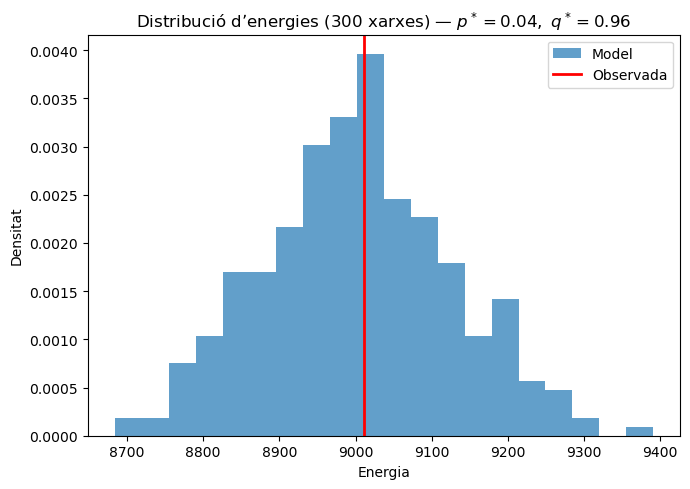

In [50]:
plt.figure(figsize=(7,5))
plt.hist(H_dist, bins=20, density=True, alpha=0.7, label="Model")
plt.axvline(H_obs, color='r', lw=2, label="Observada")
plt.title(rf"Distribució d’energies ({len(H_dist)} xarxes) — "rf"$p^*={p_inf:.2f},\ q^*={q_inf:.2f}$")

plt.xlabel("Energia")
plt.ylabel("Densitat")
plt.legend()
plt.tight_layout()
#plt.savefig(f"histograma_energies_{len(H_dist)}_xarxes.png", dpi=300) 
plt.show()



## Conclusions

La distribució d’energies obtinguda a partir de les xarxes sintètiques generades amb els paràmetres estimats p* i q*, mantenint fix el patró de wiring L_wiring_nova i utilitzant la permutació identitat, mostra un comportament unimodal i suau, coherent amb el fet que l’energia és una magnitud extensiva que agrega contribucions locals.

L’energia de la xarxa observada H_obs es troba dins de la regió típica de la distribució del model, i no en les cues extremes. Aquest fet indica que la xarxa observada és compatible amb l’ensemble generat pel model probabilístic, i suggereix que els paràmetres inferits p* i q* capturen adequadament les propietats globals de la xarxa.

En conseqüència, el model no només reprodueix valors mitjans, sinó també les fluctuacions de l’energia, reforçant la seva validesa com a descripció estadística de la xarxa observada.